Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [28]:
from sklearn.datasets import load_digits

In [29]:
digits = load_digits()
X = digits.data
y = digits.target

In [30]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

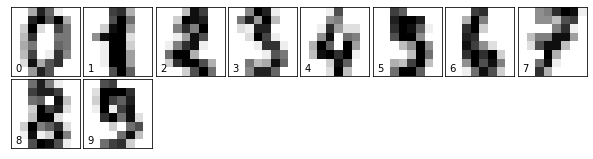

In [31]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8, 8))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(10):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [32]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState

In [33]:
import numpy as np
from numpy.linalg import norm

In [34]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = random_state
        self.ob = None
        
    def initializ_centroids(self, X):
        np.random.RandomState(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
        return centroids
    
    
        
    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        # <your code>
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            centroids = cluster_centers
            row_norm = norm(X - centroids[k, :], axis=1)
            distance[:, k] = np.square(row_norm)
        return distance
    
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        # <your code>
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k, :] = np.mean(X[nearest_clusters == k, :], axis=0)
        return centroids
    
    
    def compute_sse(self, X, labels, centroids):
        distance = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            distance[labels == k] = norm(X[labels == k] - centroids[k], axis=1)
        return np.sum(np.square(distance))
    
    def find_closest_cluster(self, distance):
        return np.argmin(distance, axis=1)
        
    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """

        assert X.shape[0] >= self.n_clusters
        # <your code>
        centroids_arr = []
        for n in range(self.n_init):
            self.cluster_centers_ = self.initializ_centroids(X)
            for i in range(self.max_iter):
                old_centroids = self.cluster_centers_
                distance = self.calculate_distances_to_centroids(X, old_centroids)
                current_labels = self.find_closest_cluster(distance)
                current_cluster_centers_ = self.update_centroids(X, current_labels)
            current_ob = self.compute_sse(X, current_labels, current_cluster_centers_)
            if self.ob == None or current_ob <= self.ob:
                self.labels = current_labels
                self.cluster_centers_ = current_cluster_centers_
                self.ob = current_ob
                if np.all(old_centroids == self.cluster_centers_):
                    break
            
        return self
            
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            distance = self.calculate_distances_to_centroids(X, self.cluster_centers_)
            return self.find_closest_cluster(distance)
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")
            


**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [35]:
km = CustomKMeans(n_clusters=10)
km.fit(X)

In [36]:
custom_kmeans_labels = km.labels
assert custom_kmeans_labels.shape == (1797,)

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [37]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

clustering = AgglomerativeClustering(n_clusters=10, linkage="ward")
hierarchical_labels = clustering.fit_predict(X)

In [38]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
kmeans_labels = kmeans.labels_

In [39]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

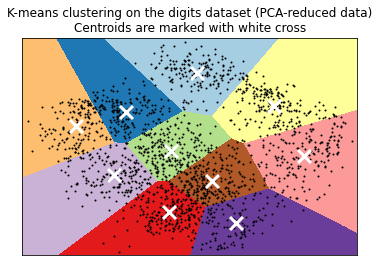

In [40]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

In [41]:
from sklearn.metrics import silhouette_score

silhouette_scores1 = []

for k in range(2, 21):
    model1 = AgglomerativeClustering(n_clusters=k, linkage="ward")
    model1.fit(X)
    score = silhouette_score(X, model1.labels_)
    print("Silhouette Score for k = ", k, "is", score)
    silhouette_scores1.append(score)

Silhouette Score for k =  2 is 0.11674033985112256
Silhouette Score for k =  3 is 0.11188954666963648
Silhouette Score for k =  4 is 0.10895989445239453
Silhouette Score for k =  5 is 0.11888125787404626
Silhouette Score for k =  6 is 0.13701122727669246
Silhouette Score for k =  7 is 0.15368571066948947
Silhouette Score for k =  8 is 0.17056308645095428
Silhouette Score for k =  9 is 0.18061975703867697
Silhouette Score for k =  10 is 0.17849659940596496
Silhouette Score for k =  11 is 0.17637337987696772
Silhouette Score for k =  12 is 0.17362319379744087
Silhouette Score for k =  13 is 0.1726407155529682
Silhouette Score for k =  14 is 0.17670992249010575
Silhouette Score for k =  15 is 0.17633457435967023
Silhouette Score for k =  16 is 0.17695214651125427
Silhouette Score for k =  17 is 0.17953047348045556
Silhouette Score for k =  18 is 0.1669829287095671
Silhouette Score for k =  19 is 0.16585394177607718
Silhouette Score for k =  20 is 0.1686039123227311


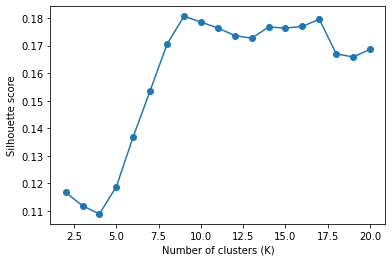

In [42]:
plt.plot(range(2, 21), silhouette_scores1, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette score')
plt.savefig('silhouette plot.png')

In [43]:
from sklearn.metrics import silhouette_score

silhouette_scores2 = []

for k in range(2, 21):
    model2 = KMeans(n_clusters=k, random_state=42)
    model2.fit(X)
    score = silhouette_score(X, model2.labels_)
    print("Silhouette Score for k = ", k, "is", score)
    silhouette_scores2.append(score)

Silhouette Score for k =  2 is 0.11832841100655983
Silhouette Score for k =  3 is 0.12649498093440542
Silhouette Score for k =  4 is 0.12801530390921514
Silhouette Score for k =  5 is 0.13819960064433023
Silhouette Score for k =  6 is 0.15156122535780586
Silhouette Score for k =  7 is 0.1594357559446549
Silhouette Score for k =  8 is 0.17885258718767805
Silhouette Score for k =  9 is 0.18916206558390755
Silhouette Score for k =  10 is 0.18244258012780126
Silhouette Score for k =  11 is 0.18284478220463565
Silhouette Score for k =  12 is 0.1827795246945175
Silhouette Score for k =  13 is 0.18561378119112062
Silhouette Score for k =  14 is 0.18364094998711486
Silhouette Score for k =  15 is 0.18637351061789284
Silhouette Score for k =  16 is 0.18712723722343658
Silhouette Score for k =  17 is 0.18435428819595015
Silhouette Score for k =  18 is 0.18636236630945008
Silhouette Score for k =  19 is 0.17068866225720106
Silhouette Score for k =  20 is 0.15368104096695667


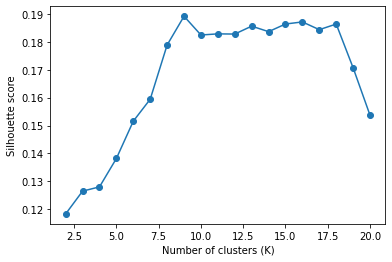

In [44]:
plt.plot(range(2, 21), silhouette_scores2, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette score')
plt.savefig('silhouette plot.png')

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

In [45]:
from sklearn.metrics.cluster import v_measure_score

In [46]:
v_scores_kmeans = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    v_scores_kmeans.append(v_measure_score(y, labels))

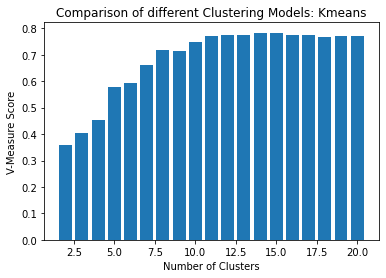

In [47]:
plt.bar(range(2, 21), v_scores_kmeans)
plt.xlabel('Number of Clusters')
plt.ylabel('V-Measure Score')
plt.title('Comparison of different Clustering Models: Kmeans')
plt.show()

In [48]:
v_scores_ac = []
for k in range(2, 21):
    model_ac = AgglomerativeClustering(n_clusters=k, linkage="ward")
    model_ac.fit(X)
    labels = model_ac.labels_
    v_scores_ac.append(v_measure_score(y, labels))

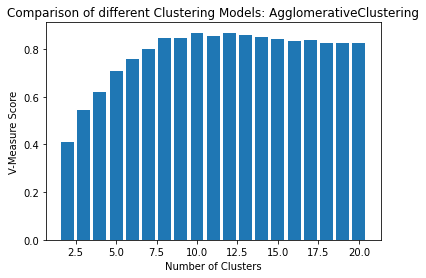

In [49]:
plt.bar(range(2, 21), v_scores_ac)
plt.xlabel('Number of Clusters')
plt.ylabel('V-Measure Score')
plt.title('Comparison of different Clustering Models: AgglomerativeClustering')
plt.show()

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [50]:
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

In [51]:
model_ac = AgglomerativeClustering(n_clusters=10)
kmeans = KMeans(n_clusters = 10)

In [52]:
# Make sparse matrix
X_sparse = csr_matrix(X)

In [53]:
for i in [2, 5, 10, 20]:
    # Create a TSVD
    tsvd = TruncatedSVD(n_components=i)
    # Conduct TSVD on sparse matrix
    X_sparse_tsvd = tsvd.fit(X_sparse).transform(X_sparse)
    print(i, 'features:')
    model_ac.fit(X_sparse_tsvd)
    labels = model_ac.labels_
    v_scores_ac = v_measure_score(y, labels)
    silhouette_score_ac = silhouette_score(X, model_ac.labels_)
    print('v_scores_ac', v_scores_ac)
    print('silhouette_score_ac', silhouette_score_ac)
    print()

    kmeans.fit(X_sparse_tsvd)
    labels = kmeans.predict(X_sparse_tsvd)
    v_scores_kmeans = v_measure_score(y, labels)
    silhouette_score_kmeans = silhouette_score(X, kmeans.labels_)
    print('v_scores_kmeans', v_scores_kmeans)
    print('silhouette_score_kmeans', silhouette_score_kmeans)
    print()

2 features:
v_scores_ac 0.3337189903948925
silhouette_score_ac -0.007681018630218928

v_scores_kmeans 0.34814856857015225
silhouette_score_kmeans 0.00645893896152001

5 features:
v_scores_ac 0.6756036446423491
silhouette_score_ac 0.1620113963829507

v_scores_kmeans 0.6343478382866305
silhouette_score_kmeans 0.16846774939978618

10 features:
v_scores_ac 0.8259753348813222
silhouette_score_ac 0.1765881132796084

v_scores_kmeans 0.721928541441945
silhouette_score_kmeans 0.18052467287257967

20 features:
v_scores_ac 0.8171311050922185
silhouette_score_ac 0.16925474788060282

v_scores_kmeans 0.741491147536787
silhouette_score_kmeans 0.18239687328406531



Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

CPU times: user 37.8 s, sys: 487 ms, total: 38.2 s
Wall time: 3.35 s


Text(0.5, 1.0, 't-SNE projection')

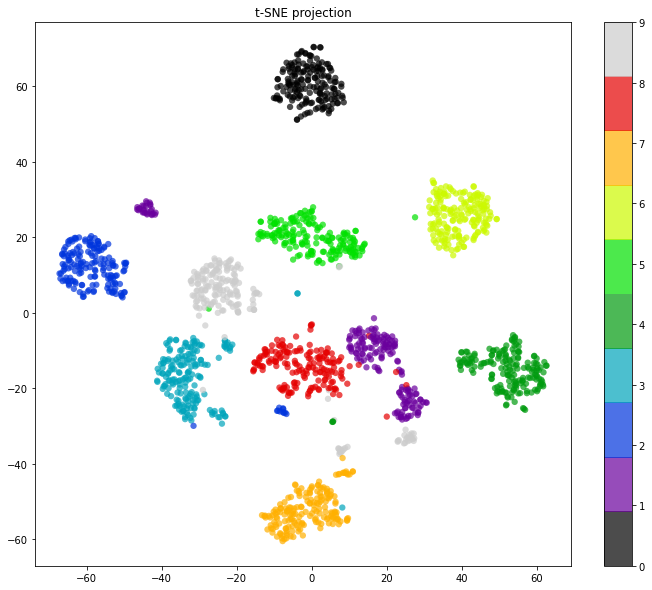

In [62]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('t-SNE projection')

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [57]:
model_ac.fit(X_2d)
labels = model_ac.labels_
v_scores_ac = v_measure_score(y, labels)
silhouette_score_ac = silhouette_score(X, model_ac.labels_)
print('v_scores_ac', v_scores_ac)
print('silhouette_score_ac', silhouette_score_ac)
print()

kmeans.fit(X_2d)
labels = kmeans.predict(X_2d)
v_scores_kmeans = v_measure_score(y, labels)
silhouette_score_kmeans = silhouette_score(X, kmeans.labels_)
print('v_scores_kmeans', v_scores_kmeans)
print('silhouette_score_kmeans', silhouette_score_kmeans)
print()

v_scores_ac 0.9093845793468884
silhouette_score_ac 0.16369833572006948

v_scores_kmeans 0.8983539438795606
silhouette_score_kmeans 0.16296594698252706



**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

*In most cases, I would recommend hierarchical clustering because it is more flexible and has less hidden assumptions about the distribution of the underlying data.*

*When using k-Means clustering, you must know how many clusters you want ahead of time (this is the 'k' value). Also, if (a) your data is not well-separated into sphere-like clusters, (b) you choose a 'k' that is not well-suited to the shape of your data, i.e. you choose a value that is too high or too low, or (c) you have weird initial values for your cluster centroids, k-means will often produce unexpected results (one strategy is to run a bunch of k-means algorithms with random starting centroids and take some common clustering result as the final result).*

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

*Clustering is the essential notion of classification, not "classifying" fresh data as the name indicates.*

*Some clustering algorithms (such as those based on centroid - kmeans, kmedians, and so on) can "label" new instances using the model established. Unfortunately, hierarchical clustering is not one of them: it does not split the input space, instead "connecting" some of the objects supplied during clustering, therefore the new point cannot be assigned to this model.*

*To utilize hclust to "classify," the only "solution" is to build another classifier on top of the labeled data provided by hclust. For example, you can now train knn on data with labels from hclust and use it to give labels to new objects (even if k=1).*

**(0.5 points)** Does dimensionality reduction improve clustering results?

*In the field of machine learning, it is useful to apply a process called dimensionality reduction to highly dimensional data. The purpose of this process is to reduce the number of features under consideration, where each feature is a dimension that partly represents the objects.
Why is dimensionality reduction important? As more features are added, the data becomes very sparse and analysis suffers from the curse of dimensionality. Additionally, it is easier to process smaller data sets.
Dimensionality reduction can be executed using two different methods:*
* Selecting from the existing features (feature selection)
* Extracting new features by combining the existing features (feature extraction)

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

*The first suggestion is to replace K with two parameters to drive these concepts separately, and introduce a different form of weighting in the joint ranking matrix. The two new parameters can then be directly interpreted as a threshold up to which rank errors are allowed and a threshold up to which rank distances are meaningful for the estimate.*

*The second suggestion could be a color representation of local quality to visually support the process of evaluating a given display, where each point in the display is colored according to its local contribution to the overall quality.*

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

In [58]:
from mnist import MNIST

mndata = MNIST('MNIST_DATABASE')
X_train, y_train = mndata.load_training()

#do the clustering
k_means = KMeans(n_clusters=len(np.unique(y_train)))
k_means.fit(X_train)
labels = k_means.labels_

In [ ]:
type(X_train

In [63]:
pca64 = PCA(n_components=64)
X_reduced = pca64.fit_transform(X_train)

print('Projecting %d-dimensional data to 2D' % X_train.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=train_y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection')

AttributeError: 'list' object has no attribute 'shape'